# First trying to plot the templates used from Goldhaber. Using the third table for the fitting. 

In [1]:
from astropy.table import Table,Column
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
%matplotlib inline

## Importing Goldhaber template and reading it in as an astropy table

In [2]:
t = "Template from Goldhaber, -18 and -20 parab turn.csv"
Table_T = Table.read(t)
len(Table_T)

76

## Re-ordering the table and plotting the template

In [3]:
new_order = ['Days','flux']
Table_T_Final = Table_T[new_order]

#Print final table
#Table_T_Final

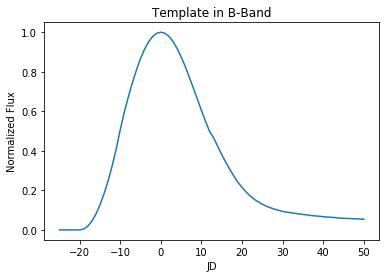

In [4]:
plt.figure()
plt.plot(Table_T_Final['Days'],Table_T_Final['flux'])

plt.title('Template in B-Band')
plt.xlabel('JD')
plt.ylabel('Normalized Flux')

## Importing in my data in the B-band

In [5]:
data = 'Photometric Data in B brightest CS.csv'

#read in again as astropy table

Table_data = Table.read(data)
len(Table_data)

#removing the random bad data points
Table_data.remove_row(73)
Table_data.remove_row(57)
#print(Table_data['flux'])

## Scale data to match the template axis

(-20, 50)

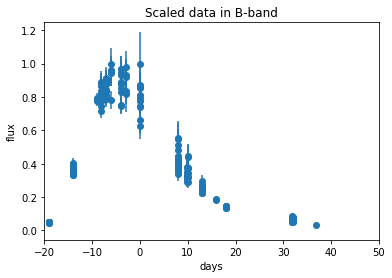

In [6]:
plt.figure()
JD_peak = Table_data['JD'][np.argmax(Table_data['flux'])]
plt.errorbar(Table_data['JD']-JD_peak,Table_data['flux']/np.max(Table_data['flux']), yerr = Table_data['fluxerr']/np.max(Table_data['flux']), fmt = 'o')
#plt.xlim(2455800,2455900)

plt.ylabel('flux')
plt.xlabel('days')
plt.title('Scaled data in B-band')

#template only goes from -9 to 50 days before and after

plt.xlim(-20,50)


## Determining which data point is at the peak of my data

In [7]:
np.argmax(Table_data['flux'])
Table_data['JD'][np.argmax(Table_data['flux'])]

2455819.6414154163

## Overlaping my data to the Goldhaber template

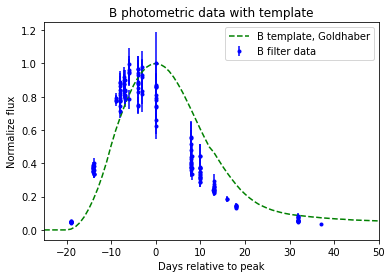

In [8]:
plt.figure()
plt.plot(Table_T_Final['Days'],Table_T_Final['flux'],'g--', label = 'B template, Goldhaber')
plt.errorbar(Table_data['JD']-JD_peak,Table_data['flux']/np.max(Table_data['flux']), yerr = Table_data['fluxerr']/np.max(Table_data['flux']), fmt = 'b.', label = 'B filter data')

plt.xlim(-25,50)
plt.legend(loc = 'upper right')
plt.xlabel('Days relative to peak')
plt.ylabel('Normalize flux')
plt.title('B photometric data with template')
plt.show()


## The next step is to interpolate over the template

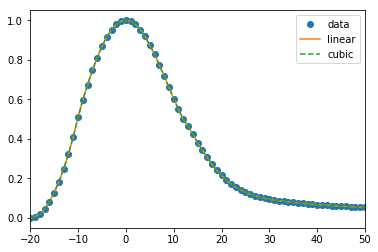

In [9]:
plt.figure()
xdata = np.array(Table_T_Final['Days']) #template days
ydata = np.array(Table_T_Final['flux']) #template flux values

f = interp1d(xdata,ydata, kind= 'linear')
f2 = interp1d(xdata,ydata, kind='cubic')

plt.plot(xdata,ydata,'o', xdata,f(xdata),'-',xdata, f2(xdata), '--')
plt.xlim(-20,50)
plt.legend(['data', 'linear', 'cubic'])
plt.show()


## Now using the interpolate template, we can use it to guess the appropriate values for Imax, S, and b for my B-band data.

<function matplotlib.pyplot.show>

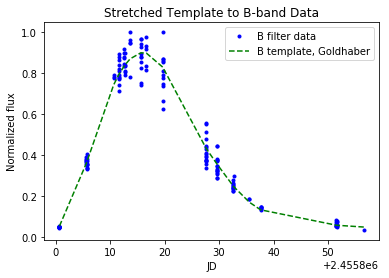

In [11]:
plt.figure()
def fit_func(xdata,Imax, s, b):
    
    z = 0.001208 #from Simbad
    tmax = 2455816 #from Richmond & Smith
    #print((((xdata - tmax) / s*(1 + z)) + b))
    return Imax * (f2(((xdata - tmax) / s*(1 + z))) + b)

happy_days = (Table_data['JD']-JD_peak) < 50 

xdata = np.array(Table_data['JD'][happy_days]) #time relative to maximum
ydata = np.array(Table_data['flux'][happy_days]/np.max(Table_data['flux'][happy_days])) #normalized flux values


popt, pcov = curve_fit(fit_func, xdata, ydata)


plt.plot(xdata,ydata, 'b.', label = 'B filter data') #my data
plt.plot(xdata, fit_func(xdata, *popt), 'g--', label = 'B template, Goldhaber') #template


plt.xlabel('JD')
plt.ylabel('Normalized flux')
plt.title('Stretched Template to B-band Data')
plt.legend()
plt.show


## Now we need to bin the data for each night.

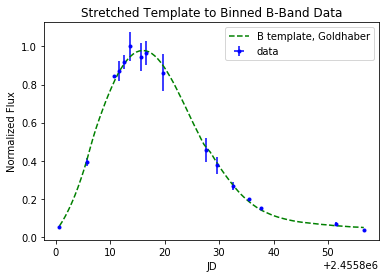

In [12]:
plt.figure()
#Lets first take xdata and ydata and put it into an astropy table
Night = np.array(np.floor(np.array(xdata + 0.5)) -1)
Newtable = Table([xdata, ydata, Night], names = ['JD', 'Flux', 'Night'])
#print(Newtable)


#now lets bin the data by grouping
data_grouped = Newtable.group_by(Night)
data_binned = data_grouped.groups.aggregate(np.mean)

#including error bars on binned data
data_binned_errors = data_grouped.groups.aggregate(np.std)
xdata_error = (data_binned_errors['JD'])
ydata_error = (data_binned_errors['Flux'])


popt_binned, pcov_binned = curve_fit(fit_func, data_binned['JD'], data_binned['Flux']/np.max(data_binned['Flux']))

#Lets plot the new binned data

lego = np.linspace(data_binned['JD'][0], data_binned['JD'][15],num=100)
plt.plot(lego, fit_func(lego, *popt_binned), 'g--', label = 'B template, Goldhaber' )
plt.errorbar(data_binned['JD'], data_binned['Flux']/np.max(data_binned['Flux']), yerr = ydata_error, xerr = xdata_error, fmt = 'b.', label = 'data')
plt.xlabel('JD')
plt.ylabel('Normalized Flux')
plt.title('Stretched Template to Binned B-Band Data')
plt.legend()


In [22]:
print(popt_binned)
#print(pcov_binned)
perr = np.sqrt(np.diag(pcov))
print(perr)
#print(pcov_binned)


[ 0.99063689  0.94435904 -0.01213043]
[ 0.01522564  0.01751513  0.0148177 ]


# Calculating the decline rate in the B-band using the equation from Perlmutter 1997 paper

In [14]:
s = popt_binned[1]
dec_rate = (1.96)*(s**-1 - 1) + 1.07
param_err = 0.17 #this is the error in 1.96
print(dec_rate)

1.18548180227


## Calculating the absolute magnitude

In [15]:
#parameters from Prieto paper
a = -19.325 #error is 0.024
a_err = 0.024

b = 0.636 #error is 0.082
b_err = 0.082

#Extinction value
A = 0.11
A_err = 0.03


M_B = a + (b*(dec_rate - 1.1))
M_B_corrected = M_B + A

print(M_B,M_B_corrected)

-19.2706335738 -19.1606335738


## Calculating the distance modulus and distance

In [16]:
'''
In order to calculate the distance modulus, the peak magnitude of the SN is needed. The peak flux value of the fit will be used,
and it will be converted back into an apparent magnitude.

'''

#From the fit, the peak flux is
Imax = popt_binned[0] * np.max(Table_data['flux'])
peak_flux = Imax*(1 + popt_binned[2])


#Converting this back into a magnitude

def magcalc(flux, zeropoint=0):
    return (-2.5*np.log10(flux)) + zeropoint
peak_mag = magcalc(peak_flux,15)



#Calculating the distance modulus

dist_mod = peak_mag - M_B_corrected

#Calculating the distance to M101

distance = (10**((dist_mod + 5)/5)) / 1e6


In [17]:
print(peak_mag,M_B_corrected, dist_mod,distance)

9.9334708337 -19.1606335738 29.0941044075 6.58902084515


nonlinear least squares = curve fit
what value did you assume for tmax

## Calculating error in the various parameters

## 1. Decline Rate Error

In [25]:
#Error in Imax, Stretch, b
perr = np.sqrt(np.diag(pcov_binned))


#This depends on the stretch method and the error in the 1.96 value which comes from the initial decline rate eq
dec_rate_error = np.sqrt((((popt_binned[1])**-1 - 1)*param_err)**2 + ((1.96/(popt_binned[1]**2))*perr[1])**2)
print('Decline Rate', dec_rate)
print('Decline Rate Error',dec_rate_error)


Decline Rate 1.18548180227
Decline Rate Error 0.0535757626109


## 2. Absolute Magnitude Error

In [26]:
#This depends on the error in the parameters a & b, which come from original eq. Also depends on decline rate error and extinxtion.
delta_M_B_a = a_err
delta_M_B_b = (dec_rate - 1.1)*b_err
delta_M_B_c = b*np.sqrt((dec_rate_error)**2)
delta_M_B_A = A_err

M_B_err = np.sqrt((delta_M_B_a)**2 + (delta_M_B_b)**2 + (delta_M_B_c)**2 + (delta_M_B_A)**2)

print('Absolute Magnitude', M_B_corrected)
print('Absolute Magnitude Error', M_B_err)

Absolute Magnitude -19.1606335738
Absolute Magnitude Error 0.0518284022927


## 3. Peak Flux Error

In [27]:
#This depends on Imax, b (from the equation from Goldhaber)
Peak_flux_error_rel = np.sqrt((perr[0]/Imax)**2 + (1+(perr[2]/popt_binned[2]))**2)
Peak_flux_error_abs = peak_flux * Peak_flux_error_rel
print('Peak Flux', peak_flux)
print('Peak Flux Relative Error',Peak_flux_error_rel)
print('Peak Flux Absolute Error', Peak_flux_error_abs)

Peak Flux 106.319191781
Peak Flux Relative Error 0.400735958268
Peak Flux Absolute Error 42.6059232005


## 4. Peak Apparent Magnitude Error

In [28]:
#This only depends on the peak flux
m_b_error = 2.5 * 0.434 * (Peak_flux_error_rel)
print('Peak Apparent Magnitude in B filter', peak_mag)
print('Peak Apparent Magnitude Error', m_b_error)

Peak Apparent Magnitude in B filter 9.9334708337
Peak Apparent Magnitude Error 0.434798514721


## 5. Distance Modulus Error

In [29]:
#This only depend on apparent and absolute magnitude values
dist_mod_error = np.sqrt((M_B_err)**2 + (m_b_error)**2)

print('Distance Modulus', dist_mod)
print('Distance Modulus Error', dist_mod_error)


Distance Modulus 29.0941044075
Distance Modulus Error 0.437876616968


## 6. Final Distance Error

In [30]:
#This only depends on distance modulus
x = np.exp(np.log(10) * (peak_mag - M_B_corrected + 5)/(5)) * 0.2 * np.log(10) * m_b_error
y = np.exp(np.log(10) * (peak_mag - M_B_corrected + 5)/(5)) * 0.2 * np.log(10) * M_B_err

dist_err = np.sqrt((x)**2 + (y)**2)/(1e6)


print('Final Distance in MPC', distance)
print('Distance Error', dist_err)

Final Distance in MPC 6.58902084515
Distance Error 1.3286736429


## Displaying everything in a table for clarity

In [31]:
r = [s, dec_rate, M_B_corrected, peak_flux, peak_mag, dist_mod, distance]
c = [perr[2], dec_rate_error, M_B_err, Peak_flux_error_abs, m_b_error, dist_mod_error, dist_err]
g = ['Stretch','Decline Rate', 'M_b', 'Peak Flux', 'm_b', 'Distance Modulus', 'Distance']

u = Table([g,r,c], names = ('Parameter', 'Value', 'Value Error'))

In [32]:
u

Parameter,Value,Value Error
str16,float64,float64
Stretch,0.94435903888,0.0169915277881
Decline Rate,1.18548180227,0.0535757626109
M_b,-19.1606335738,0.0518284022927
Peak Flux,106.319191781,42.6059232005
m_b,9.9334708337,0.434798514721
Distance Modulus,29.0941044075,0.437876616968
Distance,6.58902084515,1.3286736429
